# Inter/intra observer variations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

In [2]:
#root = r'E:\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
root = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'

## Config

In [3]:
anonymize = False
save_figures = True

In [4]:
animals = os.listdir(root)
animals

['P1_H_B6_M52',
 'P1_H_B6_M57',
 'P1_H_B6_M61',
 'P1_H_C3H_M46',
 'P1_H_C3H_M48',
 'P1_H_C3H_M54',
 'P1_H_C3H_M58',
 'P2E_M11',
 'P2E_M14',
 'P2E_M2']

Let's write a function that helps us to parse the report file

In [5]:
def get_info(report_file: str):
    
    px_size_rg = 0.05
    px_size_xr = 0.1
    
    info = {}
    with open(report_file, 'rt') as file:
        for line in file:
            if 'Isocenter coordinates' in line:
                vals = re.findall(r'\d+\.\d+', line)
                info['isocenter_coords_x'] = float(vals[0]) * px_size_rg
                info['isocenter_coords_y'] = float(vals[1]) * px_size_rg
                
            if 'Target coordinates (radiography)' in line:
                vals = re.findall(r'\d+', line)
                info['target_coords_rg_x'] = float(vals[0]) * px_size_rg
                info['target_coords_rg_y'] = float(vals[1]) * px_size_rg
                
            if 'Target coordinates (plan)' in line:
                vals = re.findall(r'\d+', line)
                info['target_coords_xr_x'] = float(vals[0]) * px_size_xr
                info['target_coords_xr_y'] = float(vals[1]) * px_size_xr
                
            if 'Transformation parameters' in line:
                _line = line.split(':')[-1]
                val1 = re.findall(r'\d+\.\d+', _line)
                val2 = re.findall(r'\d+', ' '.join(_line.split(',')[-2:]))
                vals = val1 + val2
                info['trafo_r'] = float(vals[0])
                info['trafo_angle'] = float(vals[1])
                info['trafo_x'] = float(vals[1]) * px_size_rg
                info['trafo_y'] = float(vals[2]) * px_size_rg
                
            if 'Motor origin' in line:
                vals = re.findall(r'\d+\.\d+', line)
                info['motor_origin_x'] = float(vals[0])
                info['motor_origin_y'] = float(vals[1])
                
            if 'Motor destination' in line:
                vals = re.findall(r'\d+\.\d+', line)
                info['motor_dest_x'] = float(vals[0])
                info['motor_dest_y'] = float(vals[1])            
               
    return info

### Normalization

For better comparison acros mice, it is desirable to normalize the registration parameters by subtracting the mean of the respective vaue and animal. I.e., the motor destination coordinates of animal $X$ are calculated as 

$\text{Motor_destination}_X = \text{Motor_destination}_X - mean(\text{Motor_destination}_X)$

In [6]:
colums_to_normalize = ['isocenter_coords_x', 'isocenter_coords_y', 'target_coords_xr_x', 'target_coords_xr_y', 'target_coords_rg_x',
                       'target_coords_rg_y', 'motor_origin_x', 'motor_origin_y', 'motor_dest_x', 'motor_dest_y', 'trafo_angle', 'trafo_x', 'trafo_y']

In [7]:
results = []
for animal in animals:
    _results = []
    for study in os.listdir(os.path.join(root, animal)):
        observer = study.split('_')[1]
        
        
        report_file = os.path.join(root, animal, study, 'report.txt')
        info = get_info(report_file)
        
        data_columns = list(info.keys())

        info['observer'] = observer
        info['animal'] = animal
        
        _results.append(info)
    _df = pd.DataFrame(_results)
    _df[colums_to_normalize] = _df[colums_to_normalize] - _df[colums_to_normalize].mean()
    results.append(_df)
df = pd.concat(results)

## Data overview

These are the accumulated, anonymized results. 

*Note*: The `motor_origin` columns show values of zero, since all users used the same (experiemntally set) motor origins according to the experimental notes.

In [8]:
if anonymize:
    df['observer'] = 'Observer ' + pd.Series(pd.factorize(df['observer'])[0] + 1).astype(str)

In [9]:
# Some code to make the plots below look nicer

units = {x: '[mm]' for x in df.columns if 'x' in x or 'y' in x}
units['trafo_r'] = '[a.u.]'
units['trafo_angle'] = '[°]'

labels = {}
labels['isocenter_coords_x'] = 'Isocenter coordinates$_{RG, x}$'
labels['isocenter_coords_y'] = 'Isocenter coordinates$_{RG, y}$'

labels['trafo_r'] = 'Transformation: scale '
labels['trafo_angle'] = 'Transformation: angle '
labels['trafo_x'] = 'Transformation: dx'
labels['trafo_y'] = 'Transformation: dy'

labels['target_coords_xr_x'] = 'Target coordinates$_{XR, x}$'
labels['target_coords_xr_y'] = 'Target coordinates$_{XR, y}$'

labels['target_coords_rg_x'] = 'Target coordinates$_{RG, x}$'
labels['target_coords_rg_y'] = 'Target coordinates$_{RG, y}$'

labels['motor_dest_x'] = 'Target coordinates$_{Motor, x}$'
labels['motor_dest_y'] = 'Target coordinates$_{Motor, y}$'

yrange = {x: (-2.5, 2.5) for x in df.columns if 'x' in x or 'y' in x}
yrange['trafo_r'] = (1.5, 2.5)
yrange['trafo_angle'] = (-10, 10)
yrange['motor_dest_x'] = (-5, 5)
yrange['motor_dest_y'] = (-5, 5)

In [10]:
# Remove some entries from the data which we do not wish to plot

measurement_items = list(df.columns)
measurement_items.remove('animal')
measurement_items.remove('observer')
measurement_items.remove('motor_origin_x')
measurement_items.remove('motor_origin_y')
measurement_items.remove('isocenter_coords_x')
measurement_items.remove('isocenter_coords_y')

## Inter-observer variability

We first analyze inter-observer variability. For this, we remove occurrences of repeated registration of animals by single users. More precisely, if an observer repeated the registration of the ame animal multiple times, we keep only the results of the first registration.

In [11]:
inter_observer = df.drop_duplicates(subset = ['observer', 'animal'], keep='first')
inter_observer

,isocenter_coords_x,isocenter_coords_y,target_coords_xr_x,target_coords_xr_y,target_coords_rg_x,target_coords_rg_y,trafo_r,trafo_angle,trafo_x,trafo_y,motor_origin_x,motor_origin_y,motor_dest_x,motor_dest_y,observer,animal
0,-0.00300,-0.001,-0.38,-0.120,-0.100,-2.200000e-01,2.02,-1.680,-0.08400,-0.7600,0.0,0.0,0.0860,0.2060,JM,P1_H_B6_M52
1,0.00200,-0.001,0.12,0.080,-0.200,-1.700000e-01,2.04,2.120,0.10600,1.0900,0.0,0.0,0.2060,0.1560,MS,P1_H_B6_M52
4,-0.00300,0.004,0.02,-0.020,0.100,-1.700000e-01,2.04,0.420,0.02100,0.2900,0.0,0.0,-0.1140,0.1660,TS,P1_H_B6_M52
0,0.00100,0.000,-0.14,-0.280,-0.330,-2.800000e-01,2.18,2.140,0.10700,-2.6800,0.0,0.0,0.3380,0.2900,JM,P1_H_B6_M57
1,0.00100,0.000,0.16,-0.080,0.220,-3.000000e-02,2.08,0.340,0.01700,-0.8300,0.0,0.0,-0.2120,0.0100,MS,P1_H_B6_M57
2,0.00100,0.000,-0.04,0.120,-0.130,1.200000e-01,2.08,-1.560,-0.07800,0.3200,0.0,0.0,0.1380,-0.1100,TS,P1_H_B6_M57
0,0.00125,0.000,-0.15,-0.075,-0.175,-1.375000e-01,2.06,0.425,0.02125,-0.2625,0.0,0.0,0.1700,0.1425,JM,P1_H_B6_M61
2,0.00125,0.000,0.25,0.025,0.025,-3.750000e-02,2.12,-0.575,-0.02875,-0.1625,0.0,0.0,-0.0200,0.0525,MS,P1_H_B6_M61
3,-0.00375,0.000,-0.15,-0.075,0.075,6.250000e-02,2.00,-1.075,-0.05375,1.2375,0.0,0.0,-0.0700,-0.0675,TS,P1_H_B6_M61
0,-0.00400,-0.001,-0.38,-0.100,-0.430,-3.000000e-02,2.04,0.640,0.03200,0.3800,0.0,0.0,0.4280,0.0440,JM,P1_H_C3H_M46


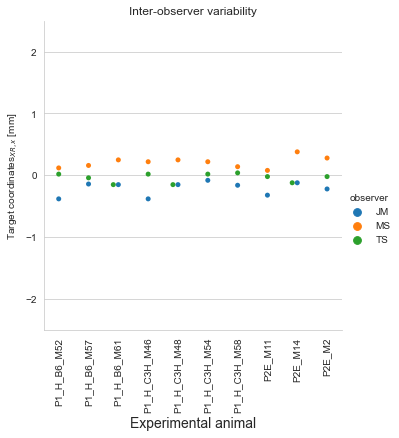

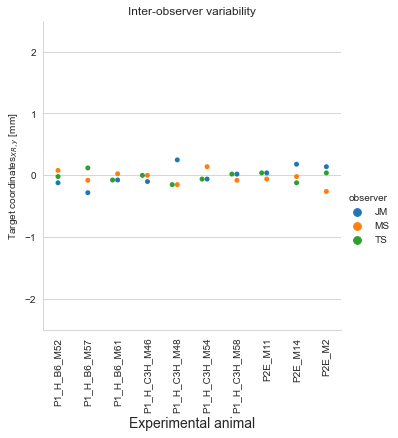

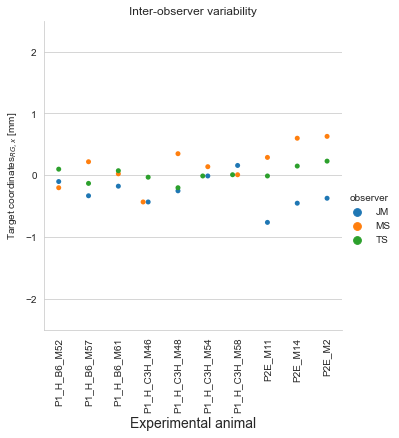

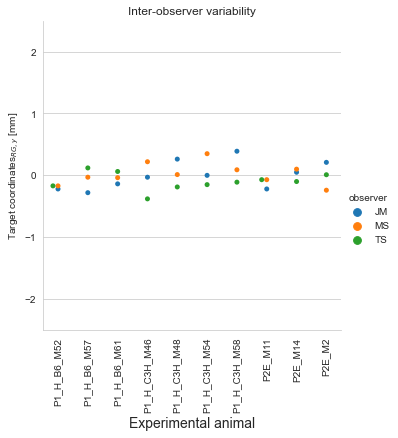

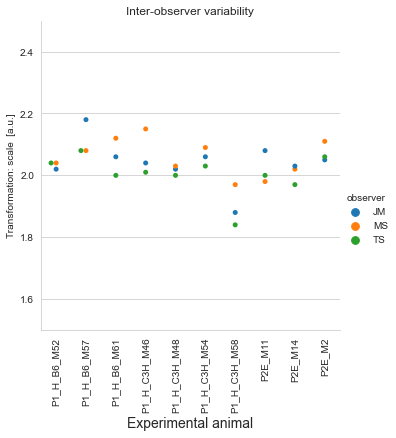

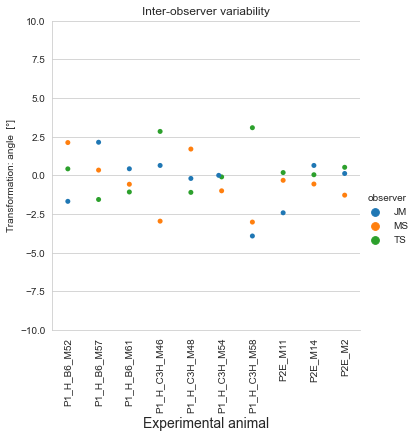

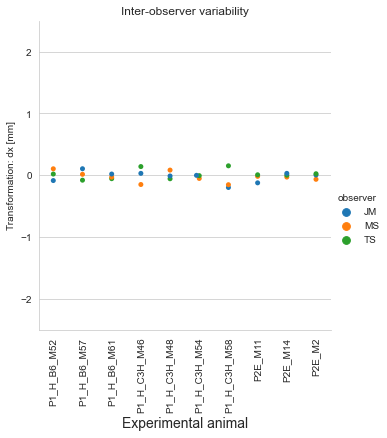

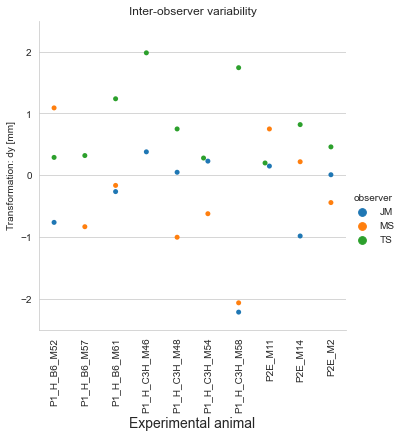

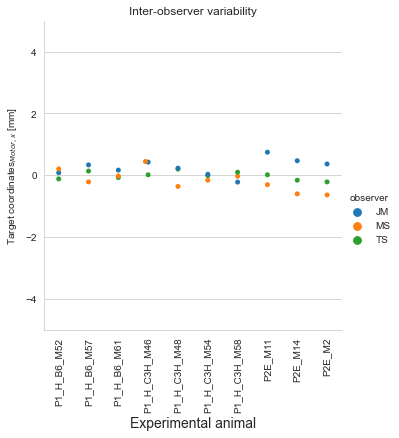

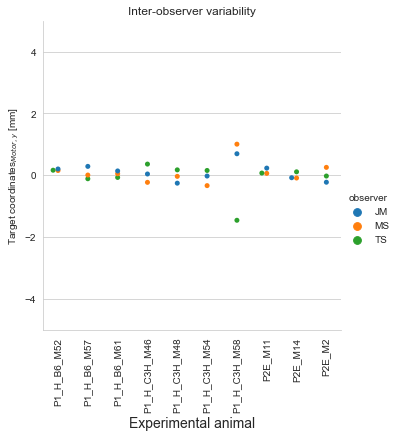

In [12]:
sns.set_style("whitegrid")
title = 'Inter-observer variability'

for key in measurement_items:
    g = sns.catplot(data=inter_observer, x='animal', y=key, hue='observer', kind='swarm')
    g.set_xticklabels(rotation=90)
    #g.set_ylabels('transformation angle [°]', fontsize=14)
    g.set_xlabels('Experimental animal', fontsize=14)
    g.set_ylabels(labels[key] + ' ' + units[key])
    g.set(ylim=yrange[key], title=title)
    
    if save_figures:
        save_file = os.path.join('.', 'figures', f'{title}_{key}.png')
        g.savefig(save_file) 

## Intra-observer variability

Next, we analyze intra-observer variability. For this, we drop all occurrences of an observer registering an animal only once.

*Note*: The data are normalized to the common mean of **all** registrations for a single animal. Hence, the plots below show not only intra-observer variation, but also whether an observer tends to over- or underestimate certain parameters with respect to the global mean parameter across all registrations for the respective animal.

In [13]:
intra_observer = df[df.duplicated(subset= ['observer', 'animal'], keep=False)]
intra_observer

,isocenter_coords_x,isocenter_coords_y,target_coords_xr_x,target_coords_xr_y,target_coords_rg_x,target_coords_rg_y,trafo_r,trafo_angle,trafo_x,trafo_y,motor_origin_x,motor_origin_y,motor_dest_x,motor_dest_y,observer,animal
1,0.00200,-0.001,0.12,0.080,-2.000000e-01,-0.1700,2.04,2.120,0.10600,1.0900,0.0,0.0,0.2060,0.1560,MS,P1_H_B6_M52
2,0.00200,-0.001,0.12,0.080,-3.552714e-15,0.3800,2.01,0.320,0.01600,0.1400,0.0,0.0,0.0360,-0.3740,MS,P1_H_B6_M52
3,0.00200,-0.001,0.12,-0.020,2.000000e-01,0.1800,2.03,-1.180,-0.05900,-0.7600,0.0,0.0,-0.2140,-0.1540,MS,P1_H_B6_M52
2,0.00100,0.000,-0.04,0.120,-1.300000e-01,0.1200,2.08,-1.560,-0.07800,0.3200,0.0,0.0,0.1380,-0.1100,TS,P1_H_B6_M57
3,-0.00400,0.000,-0.14,0.020,-1.300000e-01,-0.0800,2.04,0.140,0.00700,1.7200,0.0,0.0,0.1080,0.0800,TS,P1_H_B6_M57
4,0.00100,0.000,0.16,0.220,3.700000e-01,0.2700,1.95,-1.060,-0.05300,1.4700,0.0,0.0,-0.3720,-0.2700,TS,P1_H_B6_M57
0,0.00125,0.000,-0.15,-0.075,-1.750000e-01,-0.1375,2.06,0.425,0.02125,-0.2625,0.0,0.0,0.1700,0.1425,JM,P1_H_B6_M61
1,0.00125,0.000,0.05,0.125,7.500000e-02,0.1125,2.06,1.225,0.06125,-0.8125,0.0,0.0,-0.0800,-0.1275,JM,P1_H_B6_M61
1,0.00100,0.004,0.22,0.000,-4.300000e-01,0.2200,2.15,-2.960,-0.14800,-3.2700,0.0,0.0,0.4480,-0.2260,MS,P1_H_C3H_M46
2,0.00100,-0.001,0.02,0.100,7.000000e-02,0.2200,2.04,-0.760,-0.03800,-0.3700,0.0,0.0,-0.0820,-0.2260,MS,P1_H_C3H_M46


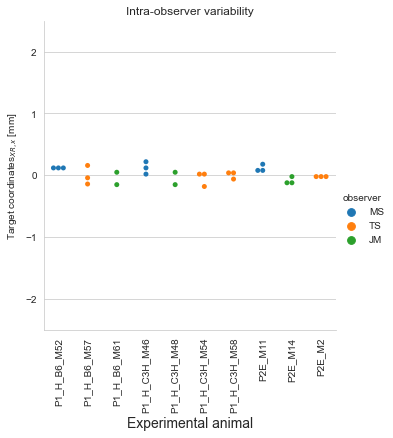

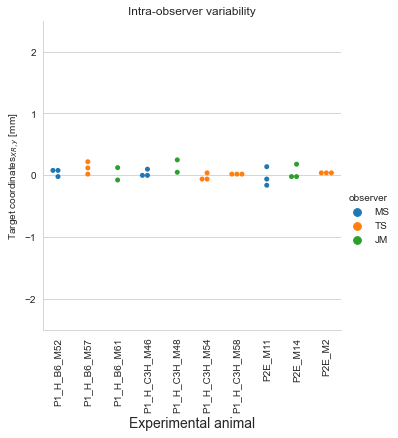

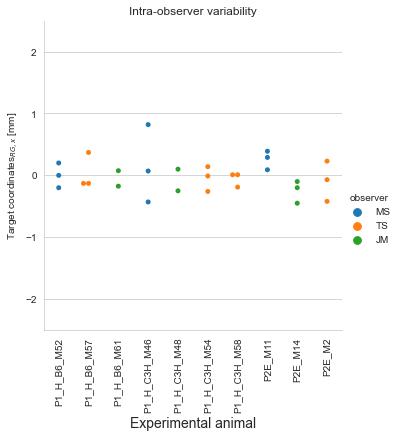

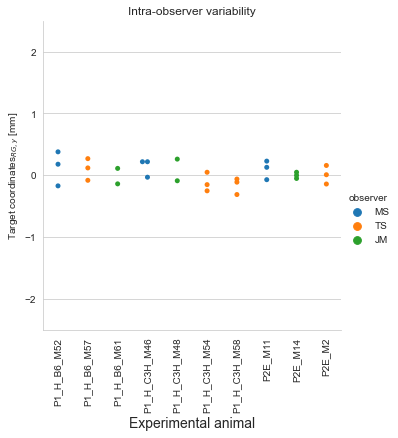

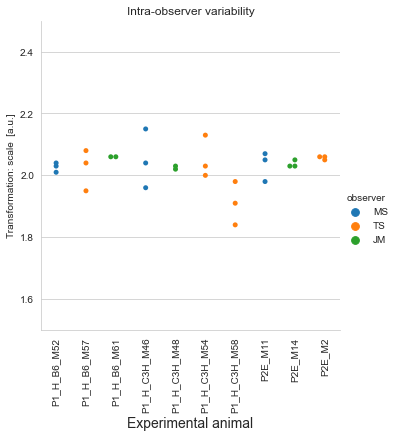

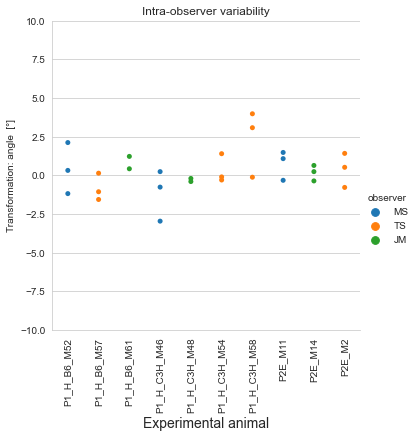

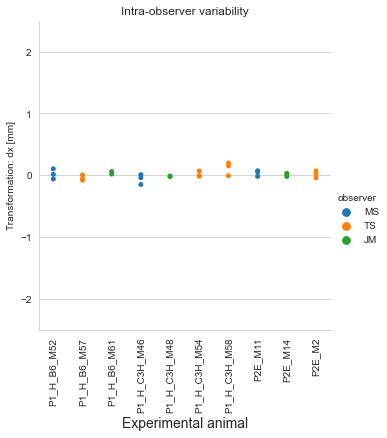

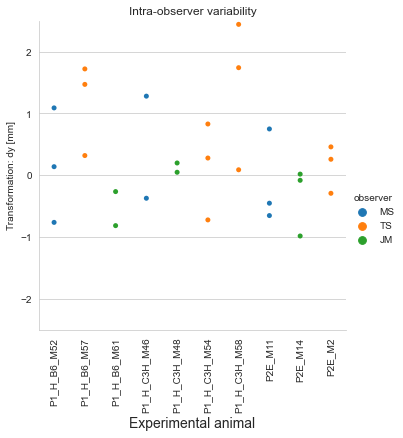

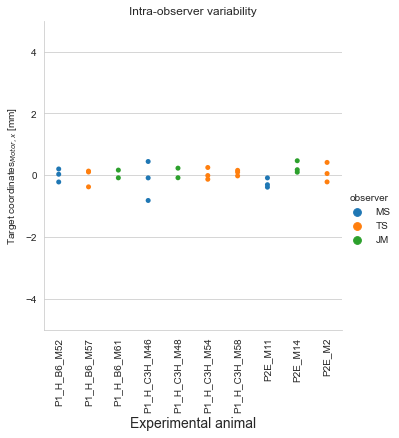

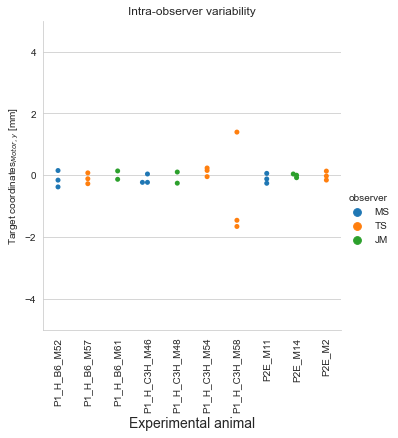

In [14]:
sns.set_style("whitegrid")
title = 'Intra-observer variability'

for key in measurement_items:
    g = sns.catplot(data=intra_observer, x='animal', y=key, hue='observer', kind='swarm')
    g.set_xticklabels(rotation=90)
    #g.set_ylabels('transformation angle [°]', fontsize=14)
    g.set_xlabels('Experimental animal', fontsize=14)
    g.set_ylabels(labels[key] + ' ' + units[key])
    g.set(ylim=yrange[key], title=title)
    
    if save_figures:
        save_file = os.path.join('.', 'figures', f'{title}_{key}.png')
        g.savefig(save_file) 